In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
file_path = '/content/drive/MyDrive/filtered_diseases_5_new.csv'
data = pd.read_csv(file_path)
data.head()

,Atelectasis,Cardiomegaly,Lung Opacity,No Finding,Pleural Effusion,dicom_id,subject_id,study_id,split
0,1,1,0,0,1,899e40a8-0562ad87-0f3253ea-4d376ad5-ad830fc2,10002013,52163036,train
1,0,0,0,0,1,419b2adf-b9c09acc-0aedfb5b-2a3818fb-2fe22456,10013569,53680741,train
2,0,0,1,0,0,b28d3fe8-09b15844-5442e33f-8e172f8e-8973f48e,10013653,54266127,train
3,0,0,1,0,1,78d48ef1-73b73217-5c083bd6-4064d6f7-709f476c,10014729,53646444,test
4,0,0,1,0,0,b91082cb-e2ca2ce8-46faa40e-03eede1a-2dd6b70b,10022373,51071301,train


In [ ]:
disease_columns = [
    'Atelectasis', 'Cardiomegaly',
    'Lung Opacity', 'No Finding', 'Pleural Effusion'
]

In [ ]:
class_distribution = data[disease_columns].sum()

In [ ]:
print("Class Distribution:")
print(class_distribution.sort_values(ascending=False))

Class Distribution:
No Finding          1126
Pleural Effusion     889
Lung Opacity         838
Atelectasis          702
Cardiomegaly         543
dtype: int64


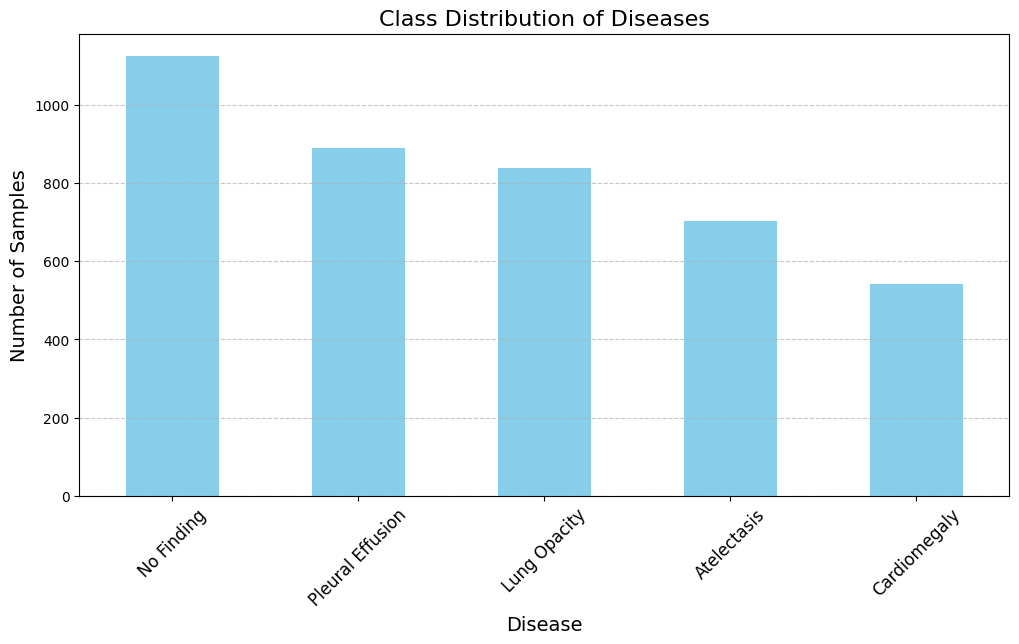

In [ ]:
# Plot the class distribution
plt.figure(figsize=(12, 6))
class_distribution.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Class Distribution of Diseases', fontsize=16)
plt.xlabel('Disease', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Create a new balanced dataset
data_balanced = pd.DataFrame()

In [ ]:
from sklearn.utils import resample

balanced_target_size = int(class_distribution.median())
# Create a new balanced dataset
data_balanced = pd.DataFrame()

for disease in disease_columns:
    # Separate positive and negative cases
    disease_positive = data[data[disease] == 1]
    disease_negative = data[data[disease] == 0]

    # Resample positive and negative cases
    disease_positive = resample(disease_positive,
                                replace=True,
                                n_samples=balanced_target_size,
                                random_state=42)
    disease_negative = resample(disease_negative,
                                replace=False,
                                n_samples=balanced_target_size,
                                random_state=42)

    # Combine the resampled data
    data_balanced = pd.concat([data_balanced, disease_positive, disease_negative], axis=0)

# Remove duplicates and reset the index
data_balanced = data_balanced.drop_duplicates().reset_index(drop=True)

# Save the balanced dataset
data_balanced.to_csv('/content/drive/MyDrive/balanced_dataset(nw).csv', index=False)

In [ ]:
ds = '/content/drive/MyDrive/balanced_dataset(nw).csv'

AttributeError: 'str' object has no attribute 'head'

In [ ]:
# Check class distribution in the balanced dataset
print("Balanced Class Distribution:")
print(data_balanced[disease_columns].sum().sort_values(ascending=False))

Balanced Class Distribution:
No Finding          1041
Pleural Effusion     856
Lung Opacity         800
Atelectasis          688
Cardiomegaly         526
dtype: int64


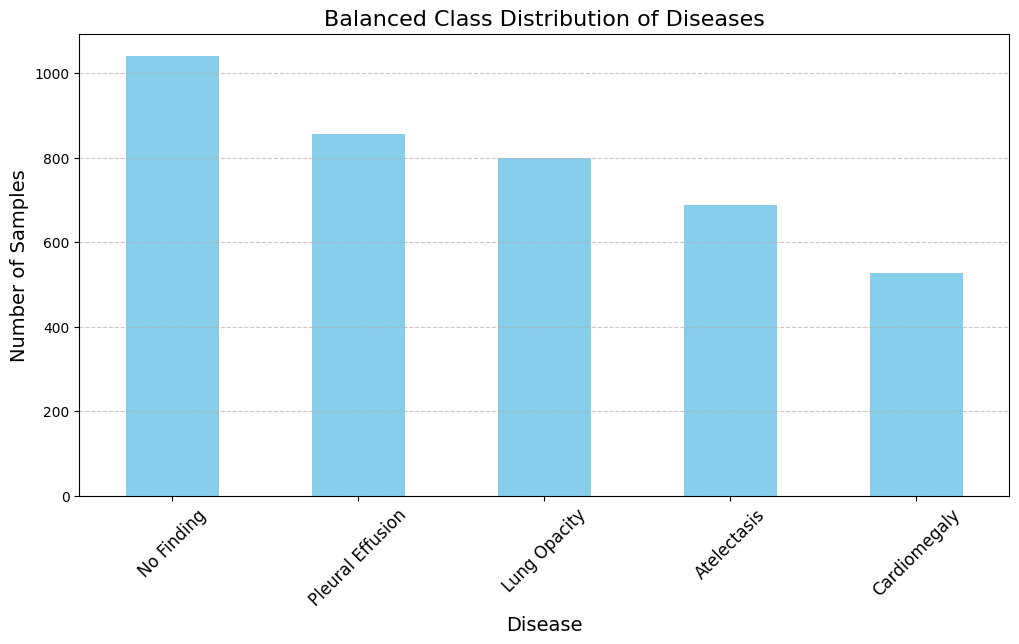

In [ ]:
# Plot the balanced class distribution
plt.figure(figsize=(12, 6))
data_balanced[disease_columns].sum().sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Balanced Class Distribution of Diseases', fontsize=16)
plt.xlabel('Disease', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
disease_columns = [
    "Atelectasis",
    "Cardiomegaly",
    "Lung Opacity",
    "No Finding",
    "Pleural Effusion",
]

In [ ]:
# '/content/drive/MyDrive/filtered_diseases_5_new.csv'
# /content/drive/MyDrive/Xray-41KB_new

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.nn import GATConv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.io import imread
from skimage.transform import rescale
from skimage.segmentation import slic
from skimage.measure import regionprops
from skimage import graph
import networkx as nx
import albumentations as A

# Paths
folder_path = r'/content/drive/MyDrive/Xray-41KB_new'
csv_path = r'/content/drive/MyDrive/filtered_diseases_5_new.csv'
output_file_path = '/content/drive/MyDrive/filtered_diseases_5_new_pcafeatures.csv'

# Preprocess Image with Rescaling and Normalization
def preprocess_image(image_path):
    image = imread(image_path, as_gray=True)
    image_rescaled = rescale(image, scale=(256 / image.shape[0], 256 / image.shape[1]), anti_aliasing=True)
    image_normalized = (image_rescaled - 0.5) / 0.5
    return image_normalized

# Augmentation
def augment_image(image):
    augment = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=10, shift_limit=0.1, p=0.5)
    ])
    augmented = augment(image=image)
    return augmented['image']

# Apply Superpixels
def apply_superpixels(image, n_segments=100):
    segments = slic(image, n_segments=n_segments, compactness=10, sigma=1, channel_axis=None)
    return segments

# Build Region Adjacency Graph (RAG)
def build_rag(image, segments):
    rag = graph.rag_mean_color(image, segments, mode='distance')
    return rag

# Convert RAG to NetworkX Graph
def convert_rag_to_networkx(rag, segments, image):
    regions = regionprops(segments + 1, intensity_image=image)
    features = np.array([region.mean_intensity for region in regions])
    G = nx.Graph()
    for node in rag.nodes:
        G.add_node(node - 1, feature=features[node - 1])
    for edge in rag.edges:
        G.add_edge(edge[0] - 1, edge[1] - 1, weight=rag.edges[edge]['weight'])
    return G, features

# Process all images in the folder with augmentation
def process_images_in_folder(folder_path):
    graph_list = []
    dicom_ids = []
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            try:
                image_path = os.path.join(folder_path, filename)
                print(f'Processing {filename}')
                image = preprocess_image(image_path)
                image = augment_image(image)
                segments = apply_superpixels(image, n_segments=100)
                rag = build_rag(image, segments)
                G, _ = convert_rag_to_networkx(rag, segments, image)
                graph_list.append(G)
                dicom_ids.append(filename.replace('.jpg', '').replace('.png', ''))
                count += 1
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    print(f"Processed {count} images.")
    return graph_list, dicom_ids

# Enhanced GAT Model with Dropout and More Layers
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=dropout)
        self.conv3 = GATConv(hidden_channels, out_channels, heads=1, dropout=dropout)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.dropout(self.conv1(x, edge_index).relu())
        x = self.dropout(self.conv2(x, edge_index).relu())
        x = self.conv3(x, edge_index)
        return x

# Initialize GAT Model
gat_model = GAT(in_channels=1, hidden_channels=128, out_channels=100, dropout=0.6)

# Focal Loss for class imbalance
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

# Feature Extraction with GAT and PCA
def extract_features_with_gat_and_pca(graph_list, n_components=50):
    extracted_features = []
    for G in graph_list:
        edge_index = torch.tensor(list(G.edges)).t().contiguous()
        x = torch.tensor([G.nodes[n]['feature'] for n in G.nodes], dtype=torch.float).unsqueeze(1)

        gat_model.eval()
        with torch.no_grad():
            feature_vector = gat_model(x, edge_index).mean(dim=0).numpy()
            extracted_features.append(feature_vector)

    # Convert to numpy array for PCA
    extracted_features = np.array(extracted_features)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(extracted_features)

    return reduced_features

# Process images
graph_list, dicom_ids = process_images_in_folder(folder_path)

# Extract features with GAT and apply PCA
features_list = extract_features_with_gat_and_pca(graph_list, n_components=50)

# Convert features to DataFrame
features_df = pd.DataFrame(features_list, columns=[f'pca_feature_{i + 1}' for i in range(50)])
features_df['dicom_id'] = dicom_ids

# Load original data and merge with features
df = pd.read_csv(csv_path)
final_df = df.merge(features_df, on='dicom_id', how='inner')

# Save the final DataFrame
final_df.to_csv(output_file_path, index=False)
print(f"Filtered features with GAT and PCA saved to {output_file_path} successfully.")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Processing bade2e07-5256c7b9-6c82d469-8a92bbf7-237b6f70.jpg
Processing baf69e92-b8da9f45-66b34a92-a0635447-4eff4dcf.jpg
Processing ba90ecf1-7e1d8a3b-1c25a0d1-24542274-40129f54.jpg
Processing bab4b376-a32096b4-dc4113fb-4585e0fc-cde1ef88.jpg
Processing bb762e03-d429be3c-d94066fa-b539ba48-d32bf8b4.jpg
Processing bb831794-2c092fc0-eeb77396-e1d8659e-824db2d6.jpg
Processing bbf0ca88-1932c5e4-7f79f26a-cbb1f990-64445441.jpg
Processing bbc02ca4-5df5c60f-eaee13ab-8d305b48-62670ec3.jpg
Processing bbeb744a-80d1677f-69ce77e9-7aa5f504-67ee1db5.jpg
Processing bbd67a3d-7091e6fc-7ab0aaa6-c32e1442-8d8ad1f7.jpg
Processing bb9b4418-6f608e8b-43f33e81-a68a6f25-163b512d.jpg
Processing bba39dde-a558e410-62ca38fd-6dac7774-657ed79b.jpg
Processing bb1080d6-e8836cbd-aed520ab-e11d20c1-9470cf76.jpg
Processing bb414e26-e6b996ff-ae5b8bfd-be547087-98a2c5bc.jpg
Processing bb0c5fdb-2c101e41-a90bd12a-68b5a55e-29106b5b.jpg
Processing bb80835f-0ac5fd34-34aba4b1-5ba1d046-6f973c53.jpg
Processing bc923ff4-85d3bf88-bee46f78-f5

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# File paths
input_csv_path = r'/content/drive/MyDrive/filtered_diseases_5_new_pcafeatures.csv'
output_csv_path = r'/content/drive/MyDrive/multi_label_encoded_dataset.csv'

# Load the dataset
df = pd.read_csv(input_csv_path)

# Define disease columns
disease_columns = ["Atelectasis", "Cardiomegaly", "Lung Opacity", "No Finding", "Pleural Effusion"]

# Multi-label encoding
df['labels'] = df[disease_columns].values.tolist()

# Define features (PCA features) and multi-label targets
feature_columns = [col for col in df.columns if 'pca_feature' in col]  # Select PCA feature columns
X = df[feature_columns].values  # Feature matrix
y = df[disease_columns].values  # Multi-label targets
# y= df['labels'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)


# Save the multi-label encoded dataset
df.to_csv(output_csv_path, index=False)
print(f"Multi-label encoded dataset saved to {output_csv_path}")

# Display the shape of the feature and label matrices
print(f"Features (X) shape: {X.shape}")
print(f"Labels (y) shape: {y.shape}")

Multi-label encoded dataset saved to /content/drive/MyDrive/multi_label_encoded_dataset.csv
Features (X) shape: (3009, 50)
Labels (y) shape: (3009, 5)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
print('X_train_shape:',X_train.shape)
print('Xtest_shape:',X_test.shape)
print('ytrain_shape:',y_train.shape)
print('ytest_shape:',y_test.shape)

print(y.shape[1])

X_train_shape: (1805, 50)
Xtest_shape: (1204, 50)
ytrain_shape: (1805, 5)
ytest_shape: (1204, 5)
5


In [ ]:
# from sklearn.model_selection import train_test_split
# # Filter rows for training and testing based on the 'split' column
# train_data = df[df["split"] == "train"]
# test_data = df[df["split"].isin(["test", "validate"])]

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # Extract feature columns (exclude metadata and labels)
# exclude_columns = [
#     "dicom_id", "subject_id", "study_id", "split","labels"
# ] + disease_columns

# X_train = train_data.drop(columns=exclude_columns)  # Features for training
# y_train = train_data[disease_columns]               # Multi-label targets for training

# X_test = test_data.drop(columns=exclude_columns)    # Features for testing
# y_test = test_data[disease_columns]                 # Multi-label targets for testing
# print(X_train)
# print(y_test)
# print("Shape of X_train:", X_train.shape)
# print("Shape of y_train:", y_train.shape)
# print("Shape of X_test:", X_test.shape)
# print("Shape of y_test:", y_test.shape)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

# Function to create the deep learning model
def create_model(input_dim, output_dim):
    model = Sequential([
        Dense(1024, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.5),
        Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.5),
        Dense(output_dim, activation='sigmoid')  # Sigmoid for multi-label classification
    ])
    return model

# Define input and output dimensions
input_dim = X.shape[1]
output_dim = y.shape[1]

# Create the model
model = create_model(input_dim, output_dim)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # Binary crossentropy for multi-label classification
              metrics=['accuracy'])

# Display the model's architecture
model.summary()

# Define callbacks for model checkpointing and early stopping
checkpoint = ModelCheckpoint('model_best.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Split data into training and testing (assuming X and y are defined as per the earlier code)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=1000,
                    batch_size=20,
                    callbacks=[checkpoint, early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                     │ (None, 1024)                │          52,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 725,125 (2.77 MB)

 Trainable params: 725,125 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1685 - loss: 0.8147
Epoch 1: val_loss improved from inf to 0.72884, saving model to model_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1688 - loss: 0.8143 - val_accuracy: 0.3887 - val_loss: 0.7288
Epoch 2/1000
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2374 - loss: 0.7520
Epoch 2: val_loss improved from 0.72884 to 0.72060, saving model to model_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2373 - loss: 0.7519 - val_accuracy: 0.3854 - val_loss: 0.7206
Epoch 3/1000
119/121 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2352 - loss: 0.7397
Epoch 3: val_loss improved from 0.72060 to 0.71581, saving model to model_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2355 - loss: 0.7397 - val_accuracy: 0.3854 - val_loss: 0.7158
Epoch 4/1000
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2566 - loss: 0.7256
Epoch 4: val_loss did not improve from 

19/19 - 0s - 11ms/step - accuracy: 0.2907 - loss: 0.6610
Test Accuracy: 29.07%
Test Loss: 0.6610
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Accuracy: 0.1030
Precision: 0.3024
Recall: 0.0839
F1-Score: 0.1219

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

     Atelectasis       0.00      0.00      0.00       151
    Cardiomegaly       0.00      0.00      0.00       102
    Lung Opacity       0.35      0.04      0.08       142
      No Finding       0.47      0.23      0.31       232
Pleural Effusion       0.45      0.05      0.09       195

       micro avg       0.46      0.08      0.14       822
       macro avg       0.26      0.06      0.10       822
    weighted avg       0.30      0.08      0.12       822
     samples avg       0.11      0.11      0.11       822



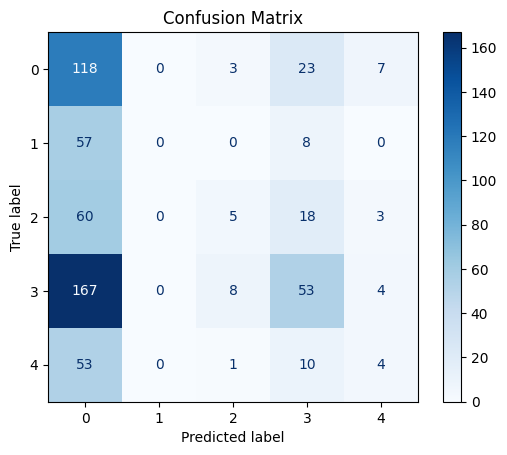

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import numpy as np


# Model evaluation on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions for the test data
y_pred_prob = model.predict(X_test)  # Get probabilities
y_pred_labels = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels (threshold = 0.5)


# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted') # Use weighted average for multi-label
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=disease_columns))

# Generate confusion matrix
# Convert y_test and y_pred_labels to NumPy arrays before using argmax
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_labels.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(n_classes))
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()